### 1. GAN first introduction



GANs are a class of unsupervised generative models which implicitly model the data density.

The basic setup is pictured above. There are two "competing" neural networks:
* The Generator wants to learn to generate realistic images that are indistinguishable from the real data. 
    - *input*: Gaussian noise random sample. *output*: a (higher dimensional) datapoint
* The Discriminator wants to tell the real & fake images apart.
    - *input*: datapoint/image, *output*: probability assigned to datapoint being real. Think binary classifier.
* The typical analogy: the generator is like a counterfeiter trying to look like real, the discriminator is the police trying to tell counterfeits from the real work.
* The key novelty of GANs is to pass the error signal (gradients) from the discriminator to the generator: the generator neural network uses the information from the competing discriminator neural network to know how to produce more realistic output.

### 2. Define the neural networks in pytorch

In [49]:
import sys
print(sys.version) # python 3.6
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
print(torch.__version__) # 1.0.1

%matplotlib inline
import matplotlib.pyplot as plt

def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
2.0.0+cpu


Let's define a small 2-layer fully connected neural network (so one hidden layer) for the discriminator D:

In [50]:
class Discriminator(torch.nn.Module):
    def __init__(self, inp_dim=784):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(inp_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = x.view(x.size(0), 784) # flatten (bs x 1 x 28 x 28) -> (bs x 784)
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.sigmoid(out)
        return out

And a small 2-layer neural network for the generator G. G takes a 100-dimensional noise vector and generates an output of the size matching the data.

In [51]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 784)
    def forward(self, x):
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.tanh(out) # range [-1, 1]
        # convert to image 
        out = out.view(out.size(0), 1, 28, 28)
        return out

In [52]:
# instantiate a Generator and Discriminator according to their class definition.
D = Discriminator()
print(D)
G = Generator()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
)


Loading the data and computing forward pass

In [53]:
# let's download the Fashion MNIST data, if you do this locally and you downloaded before,
# you can change data paths to point to your existing files
# dataset = torchvision.datasets.MNIST(root='./MNISTdata', ...)
dataset = torchvision.datasets.FashionMNIST(root='./FashionMNIST/',
                       transform=transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize((0.5,), (0.5,))]),
                       download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Let's look at a sample:

D:\38venvs\work\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


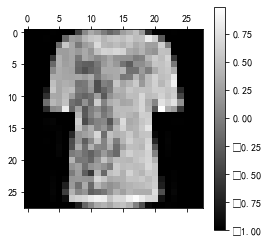

In [54]:
ix=149
x, _ = dataset[ix]
plt.matshow(x.squeeze().numpy(), cmap=plt.cm.gray)
plt.colorbar()

In [55]:
# for one image:
Dscore = D(x)
Dscore

tensor([[0.4086]], grad_fn=<SigmoidBackward0>)

In [56]:
# How you can get a batch of images from the dataloader:
xbatch, _ = next(iter(dataloader)) # 64 x 1 x 28 x 28: minibatch of 64 samples
xbatch.shape
D(xbatch) # 64x1 tensor: 64 predictions of probability of input being real.
D(xbatch).shape

torch.Size([64, 1])

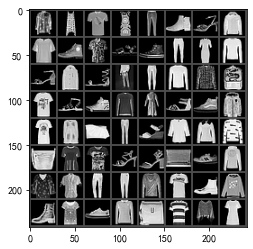

In [57]:
show_imgs(xbatch)

### 3 Intermezzo: optimization with SGD - linear regression example
We will step away from GANs for a second to introduce the core of deep learning: optimization with SGD.

Here are the core components of a basic deep learning classifier/regression setup:
* a neural network $\hat{y}=f(x, \theta)$, which takes an input $x$ and parameters $\theta$, and outputs $\hat{y}$, a prediction of label $y$.
* a loss function $\mathcal{L}(\theta) = \mathbb{E}_{x,y \sim p_d} \ell(f(x, \theta), y) \approx \sum_{x_i,y_i \sim mb} \ell(f(x_i, \theta), y_i)$.
* optimizing $\theta$ to reduce the loss, by making small updates to $\theta$ in the direction of $-\nabla_\theta \mathcal{L}(\theta)$.

pytorch is designed around these core components:
* The way to define a neural network is with `torch.nn.Module`, see how we defined the Discriminator and Generator above.
    - a `Module` defines (1) its weights and (2) defines the operations done with them.
    - initializing a module initializes the weights at random
* $\theta$ stands for all our neural network weights (everything you get from `.parameters()`)
* In the optimization loop you will evaluate a "minibatch" of samples (in our case 64) to compute the neural network output, and the loss measuring how far away those predictions are from the truth.
* To compute the gradient $\nabla_\theta \mathcal{L}(\theta)$, you call `.backward()` on the loss. This is where the magic happens: the gradient wrt all weights in the neural network is computed. They appear in a new Tensor `p.grad` for each `p in net.parameters()`
    - under the hood, this happens by keeping track of the computational graph, and reversing the computation order to "backpropagate" the loss with the chain rule.
    - [Figure which shows a bit more detail](https://tom.sercu.me/assets/201812CCNY/NN_fig.pdf)

### 3a: basic autograd example

So we said the big deal about pytorch (or other deep learning package) is **autograd = automatic differentiation** which allows to compute derivatives automatically.

Every `torch.Tensor`, let's say `x`, has an important flag `requires_grad`. If this flag is set to True, pytorch will keep track of the graph of operations that happen with this tensor.
When we finally arrive at some output (a scalar variable based on a sequence of operations on `x`), we can call `.backward()` on this output, to compute the gradient `d(output) / dx`. This gradient will end up in `x.grad`.

In [58]:
x = torch.randn(2,2, requires_grad=True)
x

tensor([[-0.0809,  0.2942],
        [-0.5748,  0.8549]], requires_grad=True)

In [59]:
# no gradient yet at this point:
print(x.grad)

None


In [60]:
y=(x**2 + x)
z = y.sum()
z

tensor(1.6477, grad_fn=<SumBackward0>)

We know from high school math that the derivative `dz / dx[i,j]` = 2*x[i,j] +1

In [61]:
z.backward()
x.grad

tensor([[ 0.8383,  1.5885],
        [-0.1496,  2.7097]])

In [62]:
2*x+1

tensor([[ 0.8383,  1.5885],
        [-0.1496,  2.7097]], grad_fn=<AddBackward0>)

You can play with this: you can introduce any tensor operation here; for example `torch.exp(torch.sin(x**2))`. Confirm that the gradient matches the analytical derivative.

More about autograd in the tutorial https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py and the docs https://pytorch.org/docs/stable/autograd.html


This was a very basic example of what pytorch autograd does for us: computing the derivatives of a scalar function $z(x)$ wrt $x$: $\nabla_x z(x)$.
In a deep learning context this will be at the basis of our optimization; now we will have
* $\mathcal{L}(\theta)$  the loss is a (scalar) function of neural network parameters (vector) $\theta$.
* autograd will allow us to call `.backward()` on the loss, which will compute the gradient of the loss with respect to neural network parameters $\nabla_\theta \mathcal{L}(\theta)$.
* For each of the parameters `p` the gradient will be in `p.grad`
* Can you confirm that for the parameters of G/D, the flag `.requires_grad` is `True`?

In [63]:
for p in G.parameters():
    print(p.grad)

None
None
None
None


### 3b: Linear regression
Let's try this for a simple linear mapping `y = f(x, theta) = <x, theta>` with $x, \theta \in \mathbb{R}^{2}$. We we want to optimize $\theta$:

In [64]:
torch.manual_seed(23231)
x1 = torch.Tensor([1, 2, 3, -3, -2])
y = torch.Tensor ([3, 6, 9, -9, -6]).view(5,1)
x2 = torch.randn(5)
x = torch.stack([x1, x2], dim=1) # 5 x 2 input. 5 datapoints, 2 dimensions.
# theta = torch.randn(1,2, requires_grad=True) # ~equal to:
theta = torch.nn.Parameter(torch.randn(1,2))
# we start theta at random initialization, the gradient will point us in the right direction.
print('x:\n', x)
print('y:\n', y)
print('theta at random initialization: ', theta)
thetatrace = [theta.data.clone()] # initial value, for logging

x:
 tensor([[ 1.0000, -1.0593],
        [ 2.0000,  1.2427],
        [ 3.0000, -0.5301],
        [-3.0000, -0.8405],
        [-2.0000, -1.6378]])
y:
 tensor([[ 3.],
        [ 6.],
        [ 9.],
        [-9.],
        [-6.]])
theta at random initialization:  Parameter containing:
tensor([[ 0.4849, -0.3917]], requires_grad=True)


Take a look at x and y. What is their correct (linear) relationship?

A: `y = 3 x1 + 0 x2`

Now we define a prediction as a linear mapping $\hat{y} = (X . \theta)$

We will compute the ordinary least squares objective (mean squared error):  $\mathcal{L}(\theta) = (\hat{y}(x,\theta) - y)^2$

Compute $\nabla_\theta \mathcal{L}(\theta)$, and

Move $\theta$ a small step opposite to that direction

In [65]:
ypred = x @ theta.t() # matrix multiply; (N x 2) * (2 x 1) -> N x 1
print('ypred:\n', ypred)
loss = ((ypred-y)**2).mean() # mean squared error = MSE
print('mse loss: ', loss.item())
loss.backward()
print('dL / d theta:\n', theta.grad)
# let's move W in that direction
theta.data.add_(-0.1 * theta.grad.data)
# Now we will reset the gradient to zero.
theta.grad.zero_()
print('theta:\n', theta)
thetatrace.append(theta.data.clone()) # for logging

ypred:
 tensor([[ 0.8998],
        [ 0.4830],
        [ 1.6623],
        [-1.1254],
        [-0.3282]], grad_fn=<MmBackward0>)
mse loss:  36.57358169555664
dL / d theta:
 tensor([[-28.0458,  -6.6600]])
theta:
 Parameter containing:
tensor([[3.2895, 0.2743]], requires_grad=True)


You can re-execute this cell above a couple of times and see how $\theta$ goes close towards the optimal value of `[3,0]`.

Text(0, 0.5, 'theta[1]')

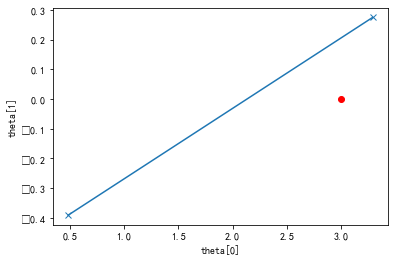

In [66]:
# Now let us plot in 2D what happened to theta during SGD optimization. In red is the true relation.
thetas = torch.cat(thetatrace, dim=0).numpy()
plt.figure()
plt.plot(thetas[:,0], thetas[:, 1], 'x-')
plt.plot(3, 0, 'ro')
plt.xlabel('theta[0]')
plt.ylabel('theta[1]')

Ok, doing this manually gives you insight what happens down to the details. But usually we do not do the gradient updates manually, it would become very cumbersome if the net becomes more complex than the simple linear layer. pytorch gives us abstractions to easily manage this complexity: 
* `nn.Linear()` (or generally  `Module`s) which do two things: (a) they contain the learnable weight, and (b) define how they operate on an input tensor to give an output.
* `module.zero_grad()` to clear the gradients, 
* `optim.SGD` with which you can do `optimizer.step()` to do a step of SGD.

In [67]:
torch.manual_seed(23801)
net = nn.Linear(2,1, bias=False)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1) # do updates with `optimizer.step()`
# x, y defined above. In a real problem we would typically get different x, y "minibatches"
# of samples from a dataloader.
for i in range(100): # 10 optimization steps (gradient descent steps)
    ypred = net(x)
    loss = ((ypred-y)**2).mean() # mean squared error = MSE
    optimizer.zero_grad()
    loss.backward()
    # and instead of W.data -= 0.1 * W.grad we do:
    optimizer.step()
print(net.weight)

Parameter containing:
tensor([[3.0000e+00, 1.0500e-07]], requires_grad=True)


### 4. Back to GANs: The min-max game.
We introduced and defined the generator G, the discriminator D, and the dataloader which will give us minibatches of real data. With the intermezzo on optimization we also understand how we optimize neural networks in pytorch.

To recap the basic idea of the min-max / adversarial game:
* The Generator and Discriminator have competing objectives, they are "adversaries".
* The Discriminator wants to assign high probability to real images and low probability to generated (fake) images
* The Generator wants its generated images to look real, so wants to modify its outputs to get high scores from the Discriminator
* We will optimize both alternatingly, with SGD steps (as before): optimize $\theta_D$ the weights of $D(x, \theta_D)$, and  $\theta_G$ the weights of $G(z, \theta_G)$.
* Final goal of the whole min-max game is for the Generator to match the data distribution: $p_G(x) \approx p_{data}(x)$.


Now what are the objective functions for each of them? As mentioned in the introduction, the objective for the discriminator is to classify the real images as real, so $D(x) = 1$, and the fake images as fake, so $D(G(z))=0$.
This is a typical binary classification problem which calls for the binary cross-entropy (BCE) loss, which encourages exactly this solution.

For G we just try to minimize the same loss that D maximizes. See how G appears inside D? This shows how the output of the generator G is passed into the Discriminator to compute the loss.


This is the optimization problem:

$$
\min _{G} \max _{D} V(D, G)=\mathbb{E}_{\boldsymbol{x} \sim p_{\text { data }}(\boldsymbol{x})}[\log D(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]
$$

We will do a single SGD step alternatingly to maximize D, then minimize G.
In fact for G we use a modified (non-saturing) loss $-\log D(G(z))$. Different modifications of the loss and the relation to the distance between distributions $p_{data}$ and $p_{G}$ became a topic of research over the last years.


In [68]:
# Remember we have defined the discriminator and generator as:
D = Discriminator()
print(D)
G = Generator()
print(G)
# Now let's set up the optimizers
optimizerD = torch.optim.SGD(D.parameters(), lr=0.01)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.01)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
)


In [69]:
# and the BCE criterion which computes the loss above:
criterion = nn.BCELoss()

In [70]:
# STEP 1: Discriminator optimization step
x_real, _ = next(iter(dataloader))
lab_real = torch.ones(64, 1)
lab_fake = torch.zeros(64, 1)
# reset accumulated gradients from previous iteration
optimizerD.zero_grad()

D_x = D(x_real)
lossD_real = criterion(D_x, lab_real)

z = torch.randn(64, 100) # random noise, 64 samples, z_dim=100
x_gen = G(z).detach()
D_G_z = D(x_gen)
lossD_fake = criterion(D_G_z, lab_fake)

lossD = lossD_real + lossD_fake
lossD.backward()
optimizerD.step()

# print(D_x.mean().item(), D_G_z.mean().item())

Some things to think about / try out / investigate:
* what are the mean probabilities for real and fake? print them and see how they change when executing the cell above a couple of times. Does this correspond to your expectation?
* can you confirm how the use of the criterion maps to the objective stated above?
* when calling backward, the derivative of the loss wrt **what** gets computed?
* what does `.detach()` do? Are the Generator parameters' gradients computed?

In [71]:
# STEP 2: Generator optimization step
# note how only one of the terms involves the Generator so this is the only one that matters for G.
# reset accumulated gradients from previous iteration
optimizerG.zero_grad()

z = torch.randn(64, 100) # random noise, 64 samples, z_dim=100
D_G_z = D(G(z))
lossG = criterion(D_G_z, lab_real) # -log D(G(z))

lossG.backward()
optimizerG.step()

print(D_G_z.mean().item())

0.49421873688697815


Again run this cell a couple of times. See how the generator increases its Discriminator score?

Some more things to ponder:
* Do the Generator parameters now receive gradients? Why (compared to previous loop)?
* From the definition of BCE loss confirm that this comes down to $-\log D(G(z))$

### Putting it all together: the full training loop

Modifications to the code:
* add device parameter to take GPU if available
* use [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) (an adaptive learning-rate variation of SGD with momentum)
* some very minimal logging

Device:  cpu
e0.i0/938 last mb D(x)=0.4295 D(G(z))=0.4777
e0.i100/938 last mb D(x)=0.9395 D(G(z))=0.3521
e0.i200/938 last mb D(x)=0.8983 D(G(z))=0.1948
e0.i300/938 last mb D(x)=0.7829 D(G(z))=0.2799
e0.i400/938 last mb D(x)=0.8040 D(G(z))=0.3354
e0.i500/938 last mb D(x)=0.8533 D(G(z))=0.2121
e0.i600/938 last mb D(x)=0.9143 D(G(z))=0.0920
e0.i700/938 last mb D(x)=0.9466 D(G(z))=0.0246
e0.i800/938 last mb D(x)=0.8657 D(G(z))=0.1227
e0.i900/938 last mb D(x)=0.6482 D(G(z))=0.4953
e1.i0/938 last mb D(x)=0.5726 D(G(z))=0.4155
e1.i100/938 last mb D(x)=0.6558 D(G(z))=0.3887
e1.i200/938 last mb D(x)=0.7156 D(G(z))=0.4268
e1.i300/938 last mb D(x)=0.7453 D(G(z))=0.3158
e1.i400/938 last mb D(x)=0.8520 D(G(z))=0.1734
e1.i500/938 last mb D(x)=0.8795 D(G(z))=0.1162
e1.i600/938 last mb D(x)=0.7303 D(G(z))=0.2748
e1.i700/938 last mb D(x)=0.7427 D(G(z))=0.2167
e1.i800/938 last mb D(x)=0.8445 D(G(z))=0.0931
e1.i900/938 last mb D(x)=0.6471 D(G(z))=0.4469
e2.i0/938 last mb D(x)=0.6641 D(G(z))=0.3851
e2.i10

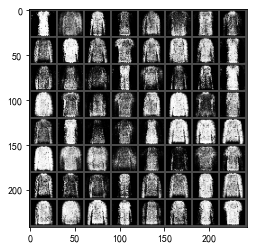

In [72]:
import numpy as np
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device: ', device)
# Re-initialize D, G:
D = Discriminator().to(device)
G = Generator().to(device)
# Now let's set up the optimizers (Adam, better than SGD for this)
optimizerD = torch.optim.SGD(D.parameters(), lr=0.03)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.03)
# optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002)
# optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002)
lab_real = torch.ones(64, 1, device=device)
lab_fake = torch.zeros(64, 1, device=device)


# for logging:
collect_x_gen = []
# Discriminator loss 
Discriminator_loss= []
# Generator loss
Generator_loss = []
fixed_noise = torch.randn(64, 100, device=device)
fig = plt.figure() # keep updating this one
plt.ion()

for epoch in range(10): # 3 epochs
    # 记录 lossD、lossG
    temp_lossD=0
    temp_loosG=0
    for i, data in enumerate(dataloader, 0):
        # STEP 1: Discriminator optimization step
        x_real, _ = next(iter(dataloader))
        x_real = x_real.to(device)
        # reset accumulated gradients from previous iteration
        optimizerD.zero_grad()

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        z = torch.randn(64, 100, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)

        
        lossD = lossD_real + lossD_fake
        # 用于画图
        temp_lossD +=lossD/len(dataloader)
        
        lossD.backward()
        optimizerD.step()
        
        # STEP 2: Generator optimization step
        # reset accumulated gradients from previous iteration
        optimizerG.zero_grad()

        z = torch.randn(64, 100, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real) # -log D(G(z))
        # 用于画图
        temp_loosG += lossG/len(dataloader)
        
        lossG.backward()
        optimizerG.step()
        if i % 100 == 0:
            x_gen = G(fixed_noise)
            show_imgs(x_gen, new_fig=False)
            fig.canvas.draw()
            print('e{}.i{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}'.format(
                epoch, i, len(dataloader), D_x.mean().item(), D_G_z.mean().item()))
    # End of epoch
    #生成器
    Generator_loss.append(temp_loosG.detach().numpy())
    #判别器
    Discriminator_loss.append(temp_lossD.detach().numpy())
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

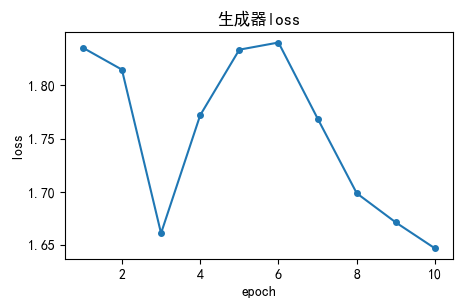

In [73]:
#绘图
from matplotlib import pyplot as plt
#设置画布大小像素点
plt.figure(figsize=(5,3),dpi=100)
plt.rc('font', family='SimHei', size=10)
plt.plot(range(1,11,1),Generator_loss,marker='o',markersize=4)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('生成器loss')  
plt.show() 

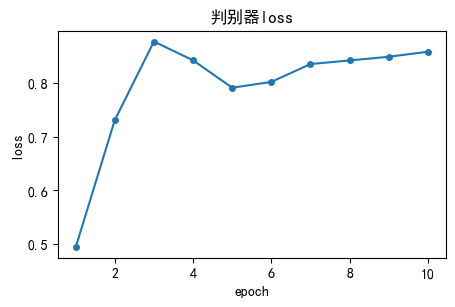

In [74]:
#绘图
from matplotlib import pyplot as plt
#设置画布大小像素点
plt.figure(figsize=(5,3),dpi=100)
plt.rc('font', family='SimHei', size=10)
plt.plot(range(1,11,1),Discriminator_loss,marker='o',markersize=4)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('判别器loss')  
plt.show() 

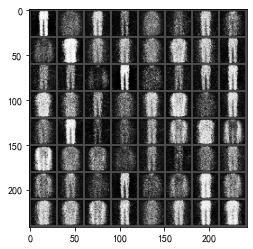

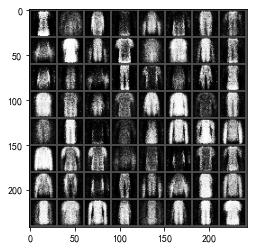

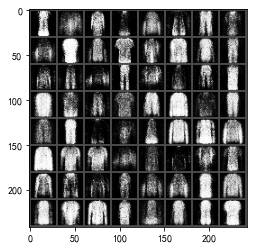

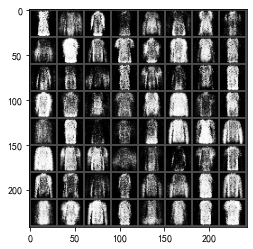

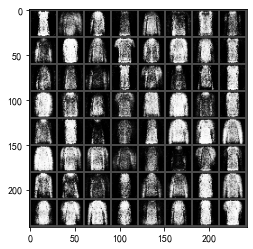

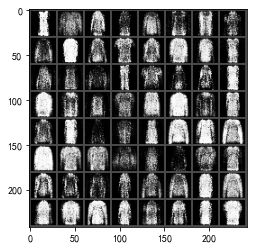

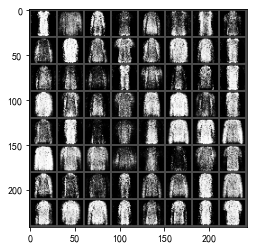

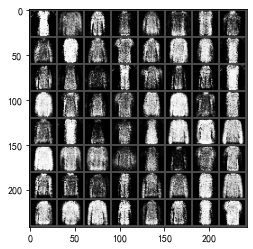

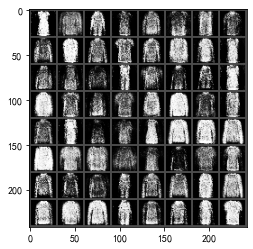

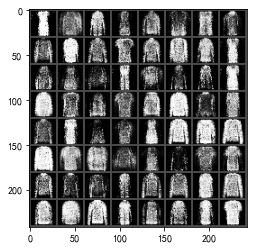

In [75]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)

## 作业要求

自定义一组随机数，生成8张图

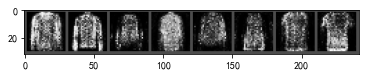

In [78]:
torch.manual_seed(23231)
z = torch.randn(8, 100, device=device) # random noise, 64 samples, z_dim=100
x_gen = G(z)
x_gen = G(z).detach()
show_imgs(x_gen)

针对自定义的100个随机数，自由挑选5个随机数，查看调整每个随机数时，生成图像的变化（每个随机数调整3次，共生成15x8张图），总结调整每个随机数时，生成图像发生的变化。

0 20 40 60 80 

position 0 	 change -1 

position 0 	 change 5 

position 0 	 change 10 

position 20 	 change -1 

position 20 	 change 5 

position 20 	 change 10 

position 40 	 change -1 

position 40 	 change 5 

position 40 	 change 10 

position 60 	 change -1 

position 60 	 change 5 

position 60 	 change 10 

position 80 	 change -1 

position 80 	 change 5 

position 80 	 change 10 



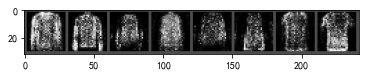

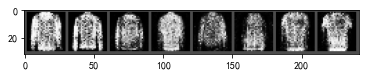

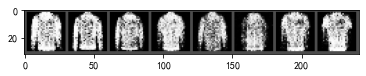

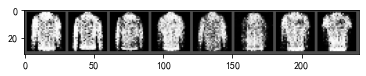

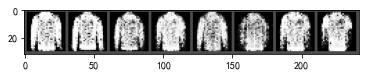

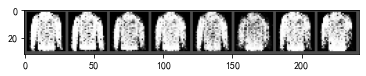

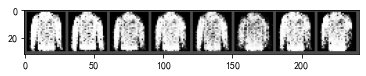

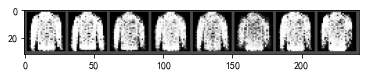

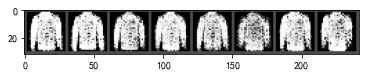

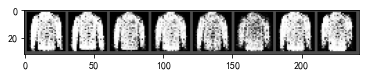

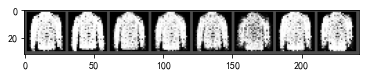

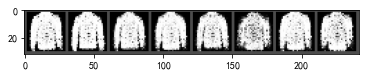

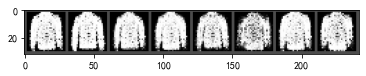

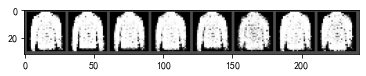

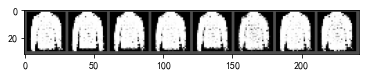

In [80]:
mylist1 = [0, 20, 40, 60, 80]
mychange = [-1,5,10]

for position in mylist1:
    for change in mychange:
        print("position %d \t change %d \n"%(position,change))
        temp = z
        for i in range(0,8):
            temp[i][position] = change
        x_gen = G(temp)
        show_imgs(x_gen, new_fig=True)

## myGAN

In [82]:
import torch.nn as nn
import torch.nn.functional as F
class myDiscriminator(torch.nn.Module):
    def __init__(self, inp_dim=784):
        super(myDiscriminator, self).__init__()
        # [64, 1, 28, 28]->[64, 64, 6, 6]
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,1,kernel_size=2,stride=2),
            nn.LeakyReLU(0.2),
        )
        self.fc=nn.Sequential(
            nn.Linear(14*14, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.LeakyReLU(0.2),
        )
        
    def forward(self, x):
        # flatten (bs x 1 x 28 x 28) -> (bs x 784)
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(x.shape)
        x = self.fc(x)
        x = torch.sigmoid(x)
        #print(x.shape)
        return x
    
model = myDiscriminator()
print(model)
result = model(xbatch)

class myGenerator(nn.Module):
    def __init__(self, z_dim=100):
        super(myGenerator, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(z_dim, 900),
            nn.LeakyReLU(0.2),
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=2,stride=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64,1,kernel_size=2,stride=1),
            nn.LeakyReLU(0.2),
        )
    def forward(self, x):
        x = self.fc1(x)
        #print(x.shape)
        # convert to image 
        x = x.view(x.size(0), 1, 30, 30)
        x = self.conv1(x)
        #print(x.shape)
        #x = torch.flatten(x, 1) # flatten all dimensions except batch
        #x = self.fc2(x)
        #x = x.view(x.size(0), 1, 28, 28)
        return x
z = torch.randn(64, 100) # random noise, 64 samples, z_dim=100
model = myGenerator()
print(model)
result = model(z)

myDiscriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 1, kernel_size=(2, 2), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (fc): Sequential(
    (0): Linear(in_features=196, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
)
myGenerator(
  (fc1): Sequential(
    (0): Linear(in_features=100, out_features=900, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 1, kernel_size=(2, 2), stride=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
  )
)


Device:  cpu
e0.i0/938 last mb D(x)=0.5015 D(G(z))=0.5002
e0.i100/938 last mb D(x)=0.8004 D(G(z))=0.4891
e0.i200/938 last mb D(x)=0.9986 D(G(z))=0.4657
e0.i300/938 last mb D(x)=1.0000 D(G(z))=0.4362
e0.i400/938 last mb D(x)=0.9765 D(G(z))=0.4059
e0.i500/938 last mb D(x)=0.9998 D(G(z))=0.3761
e0.i600/938 last mb D(x)=0.9986 D(G(z))=0.3368
e0.i700/938 last mb D(x)=0.9820 D(G(z))=0.2957
e0.i800/938 last mb D(x)=0.9725 D(G(z))=0.3046
e0.i900/938 last mb D(x)=0.8134 D(G(z))=0.3677
e1.i0/938 last mb D(x)=0.6510 D(G(z))=0.2129
e1.i100/938 last mb D(x)=0.5239 D(G(z))=0.1596
e1.i200/938 last mb D(x)=0.5482 D(G(z))=0.2920
e1.i300/938 last mb D(x)=0.8386 D(G(z))=0.0520
e1.i400/938 last mb D(x)=0.8087 D(G(z))=0.2536
e1.i500/938 last mb D(x)=0.3066 D(G(z))=0.3586
e1.i600/938 last mb D(x)=0.3893 D(G(z))=0.3467
e1.i700/938 last mb D(x)=0.7513 D(G(z))=0.4247
e1.i800/938 last mb D(x)=0.8036 D(G(z))=0.3911
e1.i900/938 last mb D(x)=0.7370 D(G(z))=0.4287
e2.i0/938 last mb D(x)=0.7550 D(G(z))=0.3808
e2.i10

e17.i400/938 last mb D(x)=0.8968 D(G(z))=0.2737
e17.i500/938 last mb D(x)=0.6841 D(G(z))=0.3365
e17.i600/938 last mb D(x)=0.5466 D(G(z))=0.1846
e17.i700/938 last mb D(x)=0.7881 D(G(z))=0.3364
e17.i800/938 last mb D(x)=0.5476 D(G(z))=0.2085
e17.i900/938 last mb D(x)=0.7257 D(G(z))=0.1218
e18.i0/938 last mb D(x)=0.6513 D(G(z))=0.3417
e18.i100/938 last mb D(x)=0.5325 D(G(z))=0.2227
e18.i200/938 last mb D(x)=0.7350 D(G(z))=0.1880
e18.i300/938 last mb D(x)=0.8346 D(G(z))=0.2522
e18.i400/938 last mb D(x)=0.7347 D(G(z))=0.3890
e18.i500/938 last mb D(x)=0.6141 D(G(z))=0.3332
e18.i600/938 last mb D(x)=0.7810 D(G(z))=0.2087
e18.i700/938 last mb D(x)=0.7777 D(G(z))=0.1237
e18.i800/938 last mb D(x)=0.7659 D(G(z))=0.3537
e18.i900/938 last mb D(x)=0.7716 D(G(z))=0.2406
e19.i0/938 last mb D(x)=0.5295 D(G(z))=0.2415
e19.i100/938 last mb D(x)=0.7031 D(G(z))=0.2457
e19.i200/938 last mb D(x)=0.6161 D(G(z))=0.3225
e19.i300/938 last mb D(x)=0.7747 D(G(z))=0.3499
e19.i400/938 last mb D(x)=0.7416 D(G(z))=0.2

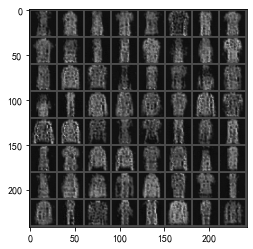

In [46]:

criterion = nn.BCELoss()

import numpy as np
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device: ', device)
# Re-initialize D, G:
D = myDiscriminator().to(device)
G = myGenerator().to(device)
# Now let's set up the optimizers (Adam, better than SGD for this)
optimizerD = torch.optim.SGD(D.parameters(), lr=0.03)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.03)
# optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002)
# optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002)
lab_real = torch.ones(64, 1, device=device)
lab_fake = torch.zeros(64, 1, device=device)


# for logging:
collect_x_gen = []
# Discriminator loss 
Discriminator_loss= []
# Generator loss
Generator_loss = []
fixed_noise = torch.randn(64, 100, device=device)
fig = plt.figure() # keep updating this one
plt.ion()

for epoch in range(20): # 3 epochs
    # 记录 lossD、lossG
    temp_lossD=0
    temp_loosG=0
    for i, data in enumerate(dataloader, 0):
        # STEP 1: Discriminator optimization step
        x_real, _ = next(iter(dataloader))
        x_real = x_real.to(device)
        # reset accumulated gradients from previous iteration
        optimizerD.zero_grad()

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        z = torch.randn(64, 100, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)

        
        lossD = lossD_real + lossD_fake
        # 用于画图
        temp_lossD +=lossD/len(dataloader)
        
        lossD.backward()
        optimizerD.step()
        
        # STEP 2: Generator optimization step
        # reset accumulated gradients from previous iteration
        optimizerG.zero_grad()

        z = torch.randn(64, 100, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real) # -log D(G(z))
        # 用于画图
        temp_loosG += lossG/len(dataloader)
        
        lossG.backward()
        optimizerG.step()
        if i % 100 == 0:
            x_gen = G(fixed_noise)
            show_imgs(x_gen, new_fig=False)
            fig.canvas.draw()
            print('e{}.i{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}'.format(
                epoch, i, len(dataloader), D_x.mean().item(), D_G_z.mean().item()))
    # End of epoch
    #生成器
    Generator_loss.append(temp_loosG.detach().numpy())
    #判别器
    Discriminator_loss.append(temp_lossD.detach().numpy())
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

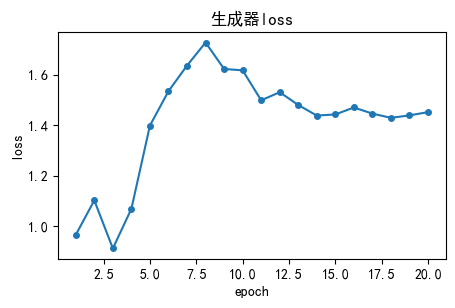

In [47]:
#绘图
from matplotlib import pyplot as plt
#设置画布大小像素点
plt.figure(figsize=(5,3),dpi=100)
plt.rc('font', family='SimHei', size=10)
plt.plot(range(1,21,1),Generator_loss,marker='o',markersize=4)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('生成器loss')  
plt.show() 

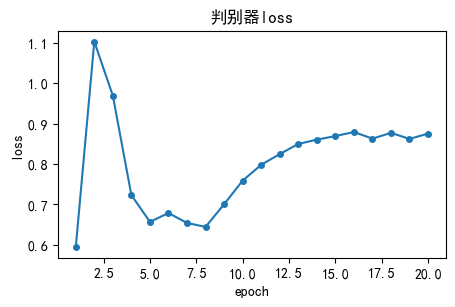

In [48]:
#绘图
from matplotlib import pyplot as plt
#设置画布大小像素点
plt.figure(figsize=(5,3),dpi=100)
plt.rc('font', family='SimHei', size=10)
plt.plot(range(1,21,1),Discriminator_loss,marker='o',markersize=4)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('判别器loss')  
plt.show() 

Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
)
